# Ships in Satellite Imagery Dataset from Kaggle

In [1]:
# import modules
import json, sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

/home/halfendt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load json data
f = open(r'/mnt/c/Users/DeWayne Halfen/Documents/Data Science/DataSets/ships-in-satellite-imagery/shipsnet.json')
dataset = json.load(f)
f.close()

In [3]:
# Convert to dataframe and examine data
ship_df = pd.DataFrame(dataset)
ship_df.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [4]:
ship_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
data         4000 non-null object
labels       4000 non-null int64
locations    4000 non-null object
scene_ids    4000 non-null object
dtypes: int64(1), object(3)
memory usage: 125.1+ KB


In [5]:
# Convert data and labels to integers in numpy array
data = np.array(dataset['data']).astype('uint8')
labels = np.array(dataset['labels']).astype('uint8')

In [43]:
# Examine number of ship/non-ship images
print('Number of Non-Ship Images: {}'.format(np.sum(labels==0)))
print('Number of Ship Images: {}'.format(np.sum(labels==1)))

Number of Non-Ship Images: 3000
Number of Ship Images: 1000


In [7]:
# Examine sizes of arrays
print(data.shape)
print(labels.shape)

(4000, 19200)
(4000,)


In [8]:
# 4000 visible satellire images of type RGB 3*80*80=19200, so each image is 80x80
# Need to reshape image data
x = data.reshape([-1, 3, 80, 80])
print(x.shape)

# Transpose array from (4000,3,80,80) to (4000,80,80,3), so .transpose([0,2,3,1])
x = x.transpose([0,2,3,1])
print(x.shape)

(4000, 3, 80, 80)
(4000, 80, 80, 3)


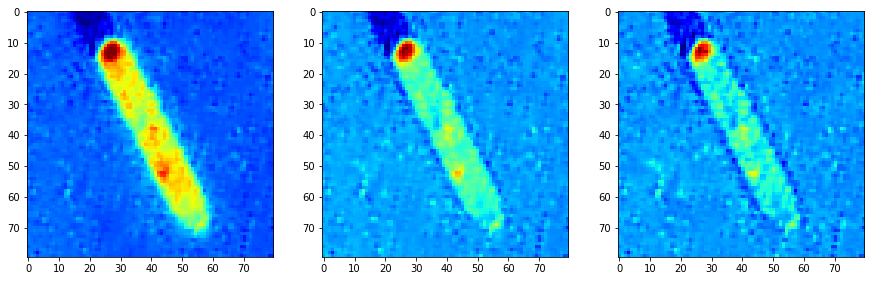

In [9]:
# Examine an image in each spectral layer (RGB)

image = 10
plt.figure(2, figsize = (5*3, 5*1))
plt.set_cmap('jet')

# Show each channel
plt.subplot(1, 3, 1)
plt.imshow(x[image][:,:,0]) #red

plt.subplot(1, 3, 2)
plt.imshow(x[image][:,:,1]) #green

plt.subplot(1, 3, 3)
plt.imshow(x[image][:,:,2]) #blue
    
plt.show()

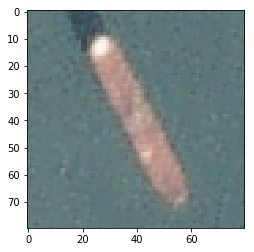

In [10]:
# Show image in real color
plt.imshow(x[10])
plt.show()

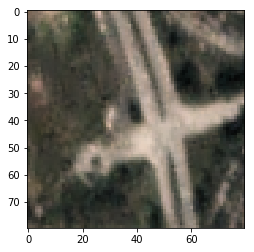

In [11]:
# Show last image (Non-ship)
plt.imshow(x[3999,:,:,:])
plt.show()

In [12]:
# Change the labels from categorical to one-hot encoding
y = to_categorical(labels)
y.shape

(4000, 2)

In [13]:
# Display the change for categorical label using one-hot encoding
print('Original label:', labels[0])
print('After conversion to one-hot:', y[0])

Original label: 1
After conversion to one-hot: [0. 1.]


In [14]:
# Split data in training and testing data, stratified by labels
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42, stratify=y)

# Print out sizes of the training and testing data
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3200, 80, 80, 3), (3200, 2), (800, 80, 80, 3), (800, 2))

In [15]:
# Regularize X data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.
X_test = X_test / 255.

In [16]:
# Setup Convolutional Neural Network

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='linear', input_shape=X_train[0].shape, padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
#model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
#model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [17]:
# Complie model
adam = Adam(lr=0.0001)
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

In [18]:
# Exmine model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 80, 80, 64)        1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 80, 80, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 40, 40, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25600)             0         
__________

In [19]:
# Train neural network
train = model.fit(X_train, y_train, batch_size=64, epochs=30, verbose=1,
                  validation_data=(X_test, y_test), callbacks=[early_stopping_monitor])

Train on 3200 samples, validate on 800 samples
Epoch 1/30
3200/3200 [==============================] - 158s 49ms/step - loss: 0.4592 - acc: 0.7897 - val_loss: 0.2980 - val_acc: 0.8712
Epoch 2/30
3200/3200 [==============================] - 156s 49ms/step - loss: 0.2720 - acc: 0.8881 - val_loss: 0.2096 - val_acc: 0.9050
Epoch 3/30
3200/3200 [==============================] - 163s 51ms/step - loss: 0.2016 - acc: 0.9188 - val_loss: 0.1615 - val_acc: 0.9387
Epoch 4/30
3200/3200 [==============================] - 168s 52ms/step - loss: 0.1740 - acc: 0.9353 - val_loss: 0.1455 - val_acc: 0.9375
Epoch 5/30
3200/3200 [==============================] - 164s 51ms/step - loss: 0.1462 - acc: 0.9463 - val_loss: 0.1288 - val_acc: 0.9537
Epoch 6/30
3200/3200 [==============================] - 156s 49ms/step - loss: 0.1431 - acc: 0.9394 - val_loss: 0.1291 - val_acc: 0.9537
Epoch 7/30
3200/3200 [==============================] - 156s 49ms/step - loss: 0.1313 - acc: 0.9494 - val_loss: 0.1183 - val_acc: 0

In [20]:
# Save best model
model.save("model_ships.h5py")

In [21]:
# Examine test loss and accuracy
test_eval = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
test_eval

800/800 [==============================] - 12s 15ms/step


[0.11227974146604539, 0.965]

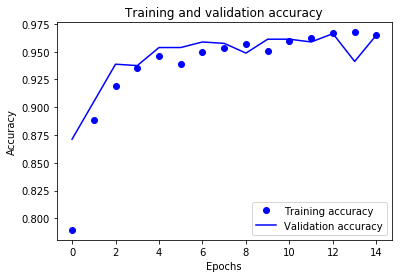

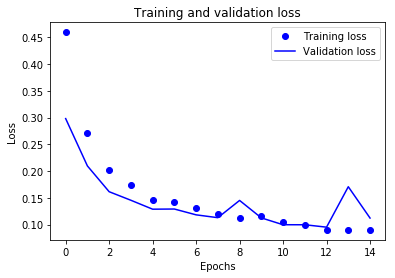

In [22]:
# Plot training and validation (test) accuracy and loss history during training epochs
accuracy = train.history['acc']
val_accuracy = train.history['val_acc']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [23]:
# Use best fit model to predict test labels
predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, y_test[:,1].shape

((800,), (800,))

Found 772 correct labels


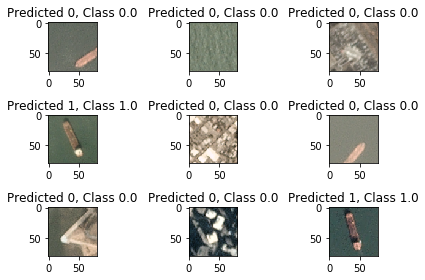

In [24]:
# Examine correctly labeled images 
correct = np.where(predicted_classes==y_test[:,1])[0]
print('Found %d correct labels' % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct], interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[:,1][correct]))
    plt.tight_layout()

Found 28 incorrect labels


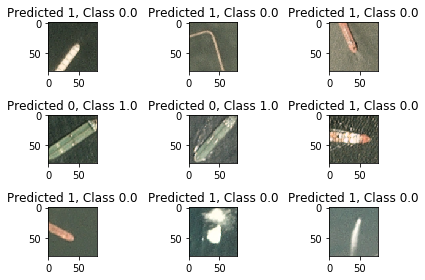

In [25]:
# Examine incorrectly labeled images 
incorrect = np.where(predicted_classes!=y_test[:,1])[0]
print('Found %d incorrect labels' % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect], interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[:,1][incorrect]))
    plt.tight_layout()

In [26]:
# Print out classification report for test data
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(2)]
print(classification_report(y_test[:,1], predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.99      0.96      0.98       600
    Class 1       0.89      0.98      0.93       200

avg / total       0.97      0.96      0.97       800



In [27]:
# Calculate confusion matrix on test data
np.set_printoptions(threshold=np.inf)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test[:,1], predicted_classes)
print(confusion_matrix)

[[576  24]
 [  4 196]]


In [ ]:
# Use model on image of ships in satellite image of San Francisco Bay

In [46]:
# Import module
from PIL import Image

# Load image
image = Image.open('/mnt/c/Users/DeWayne Halfen/Documents/Data Science/DataSets/ships-in-satellite-imagery/sfbay_2.png')
picture = image.load()

In [47]:
# Determine size of image
spectral_layers=3
width = image.size[0]
height = image.size[1]

# Create vector of image pixels
picture_vector = []
for channel in range(spectral_layers):
    for y in range(height):
        for x in range(width):
            picture_vector.append(picture[x, y][channel])

In [48]:
# Transform image into numpy array and reorder layers
picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([spectral_layers, height, width]).transpose(1, 2, 0)

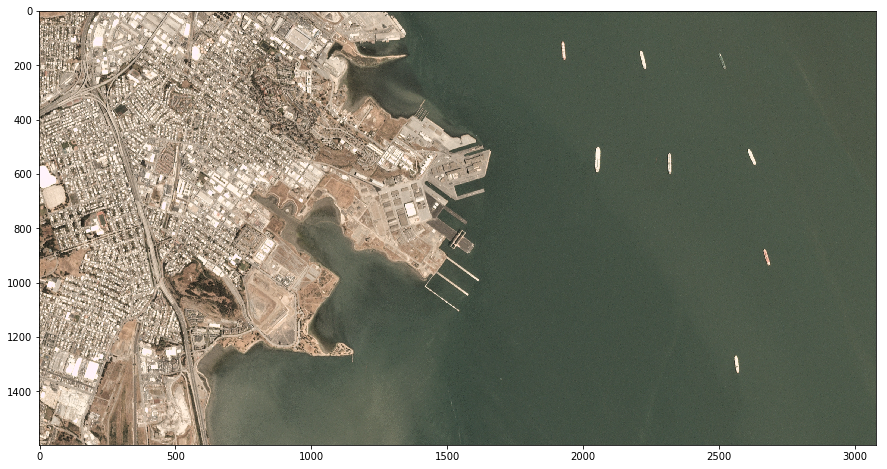

In [49]:
# Display image
plt.figure(figsize = (15, 30))
plt.imshow(picture_tensor)
plt.show()

In [50]:
# Reorder image layers for processing
picture_tensor = picture_tensor.transpose(2,0,1)

In [51]:
# Define bounding box that will be used to search image for ships
def box(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = picture_tensor[0][y+i][x+j]
            area_study[1][i][j] = picture_tensor[1][y+i][x+j]
            area_study[2][i][j] = picture_tensor[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study.transpose([0,2,3,1])
    area_study = area_study / 255
    sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
    return area_study

In [52]:
# Determine if ship is in image
def not_near(x, y, s, coordinates):
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result

In [53]:
# Draw white square for bounding box
def show_ship(x, y):
    thickness=5
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x+th+80] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y-th][x+i] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+th+80][x+i] = -1

X:1270 Y:0  [[0.05803799 0.941962  ]]


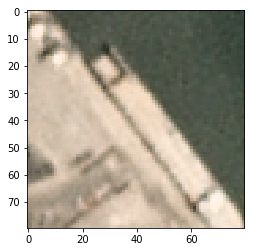

X:1890 Y:80  [[0.03837587 0.96162415]]


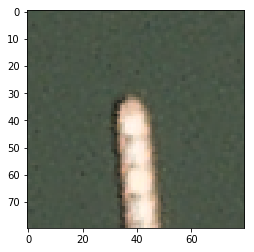

X:2180 Y:120  [[0.03391641 0.9660836 ]]


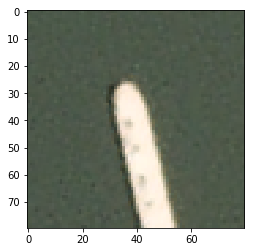

X:1240 Y:130  [[0.0418451 0.9581549]]


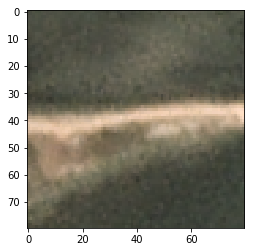

X:1490 Y:430  [[0.07860655 0.9213934 ]]


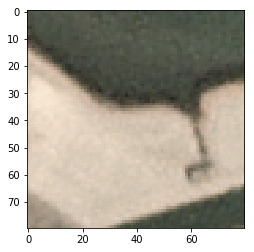

X:2570 Y:480  [[0.06184813 0.9381519 ]]


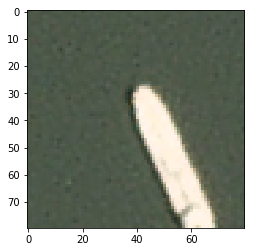

X:2020 Y:490  [[0.0762479 0.9237521]]


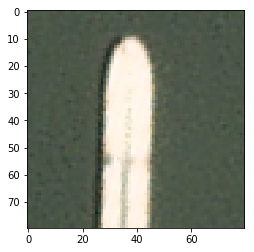

X:2280 Y:490  [[0.03095975 0.9690402 ]]


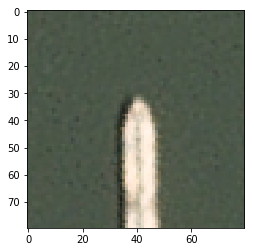

X:2630 Y:840  [[0.0517589  0.94824106]]


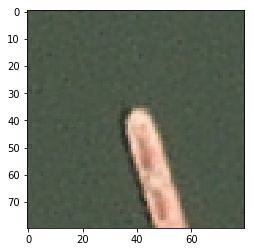

X:1550 Y:930  [[0.07509702 0.924903  ]]


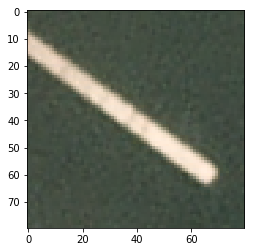

X:1070 Y:1200  [[0.03178001 0.96822006]]


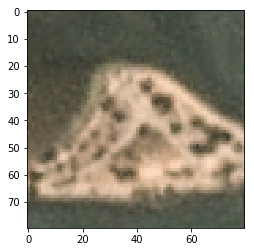

X:2530 Y:1250  [[0.0286058  0.97139424]]


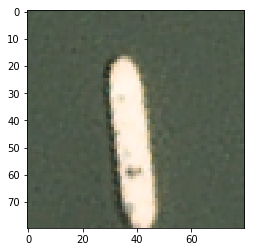

X:3000 Y:1510  

In [55]:
# Step across image searching for ships using bounding box
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = box(x*step, y*step)
        loss_acc = model.predict(area)
        if loss_acc[0][1] > 0.92 and not_near(x*step, y*step, 88, coordinates):
            coordinates.append([[x*step, y*step]])
            print(loss_acc)
            plt.imshow(area[0])
            plt.show()

In [56]:
# Get coordinates of identified ships
for e in coordinates:
     show_ship(e[0][0], e[0][1])

In [57]:
# Transpose image back for display
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape

(1597, 3081, 3)

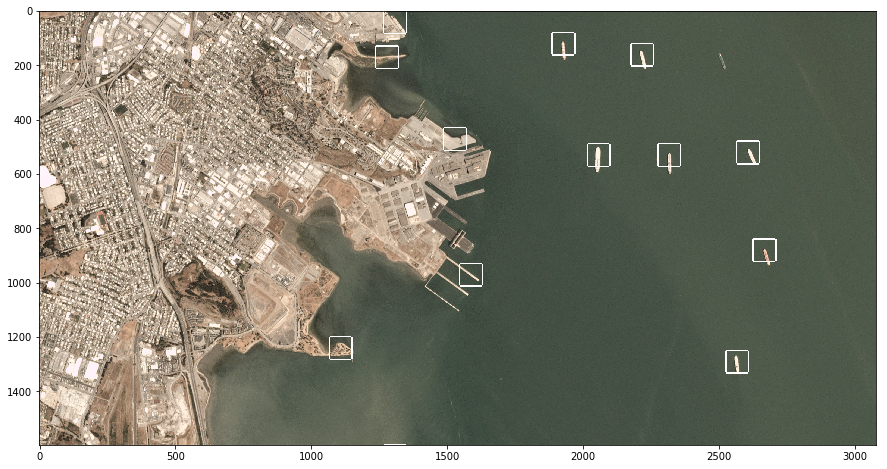

In [58]:
# Display image with ships identified by white bounding box
plt.figure(figsize = (15, 30))
plt.imshow(picture_tensor)
plt.show()